<a href="https://colab.research.google.com/github/nahid-muneer/Final_capstone/blob/main/Final_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install pathway bokeh --quiet # This cell may take a few seconds to execute.

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import warnings
warnings.filterwarnings("ignore")






In [28]:
# Load dataset
df = pd.read_csv('dataset.csv')
df

# You can find the sample dataset here: https://drive.google.com/file/d/1D479FLjp9aO3Mg8g6Lpj9oRViWacurA6/view?usp=sharing

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00
...,...,...,...,...,...,...,...,...,...,...,...,...
18363,18363,Shopping,1920,26.150504,91.733531,1517,truck,average,6,0,19-12-2016,14:30:00
18364,18364,Shopping,1920,26.150504,91.733531,1487,car,low,3,0,19-12-2016,15:03:00
18365,18365,Shopping,1920,26.150504,91.733531,1432,cycle,low,3,0,19-12-2016,15:29:00
18366,18366,Shopping,1920,26.150504,91.733531,1321,car,low,2,0,19-12-2016,16:03:00


In [29]:
# Combine date and time into one datetime field
df['Timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    format='%d-%m-%Y %H:%M:%S',
    errors='coerce'  # sets invalid parsing as NaT
)

# Sort by lot and time
df = df.sort_values(by=['SystemCodeNumber', 'Timestamp'])

# Normalize vehicle type
vehicle_weights = {'car': 1.0, 'bike': 0.6, 'truck': 1.5}
df['VehicleWeight'] = df['VehicleType'].map(vehicle_weights)

# Encode traffic levels
traffic_weights = {'low': 1, 'medium': 2, 'high': 3}
df['TrafficWeight'] = df['TrafficConditionNearby'].map(traffic_weights)

# Reset index
df = df.reset_index(drop=True)

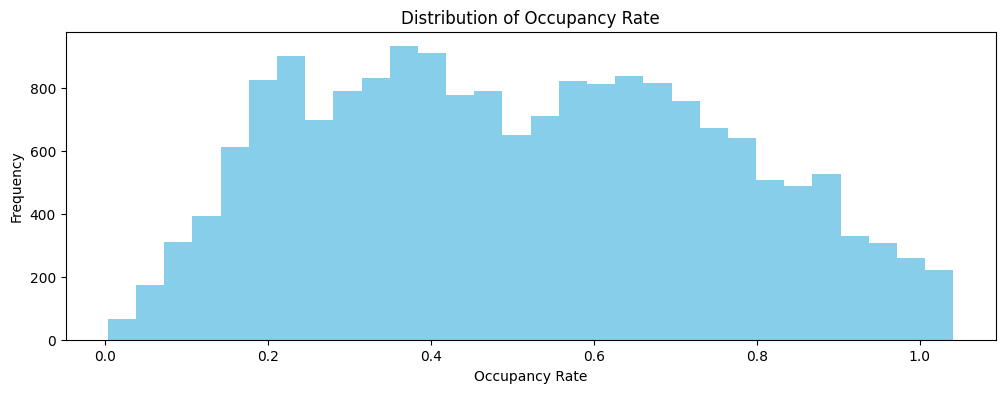

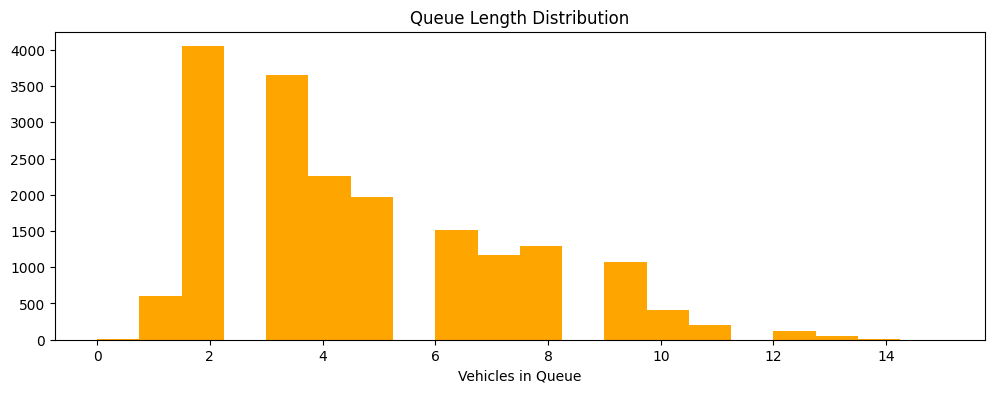

In [30]:
# Occupancy distribution
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']

plt.figure(figsize=(12,4))
plt.hist(df['OccupancyRate'], bins=30, color='skyblue')
plt.title("Distribution of Occupancy Rate")
plt.xlabel("Occupancy Rate")
plt.ylabel("Frequency")
plt.show()

# Queue Lengths
plt.figure(figsize=(12,4))
plt.hist(df['QueueLength'], bins=20, color='orange')
plt.title("Queue Length Distribution")
plt.xlabel("Vehicles in Queue")
plt.show()


In [31]:
def model1_baseline_price(df, alpha=2.0, base_price=10.0):
    df['BaselinePrice'] = base_price
    for i in range(1, len(df)):
        if df.loc[i, 'SystemCodeNumber'] == df.loc[i-1, 'SystemCodeNumber']:
            delta = alpha * (df.loc[i-1, 'Occupancy'] / df.loc[i-1, 'Capacity'])
            df.loc[i, 'BaselinePrice'] = df.loc[i-1, 'BaselinePrice'] + delta
        else:
            df.loc[i, 'BaselinePrice'] = base_price
    return df


In [32]:
def model2_demand_price(df, base_price=10.0, λ=0.5):
    # Demand formula
    df['RawDemand'] = (
        0.4 * df['OccupancyRate'] +
        0.3 * df['QueueLength'] +
        0.2 * df['IsSpecialDay'] +
        0.3 * df['VehicleWeight'] -
        0.3 * df['TrafficWeight']
    )

    # Normalize demand
    scaler = MinMaxScaler()
    df['NormDemand'] = scaler.fit_transform(df[['RawDemand']])

    # Apply pricing logic
    df['DemandPrice'] = base_price * (1 + λ * df['NormDemand'])

    # Clip between 0.5x and 2x base
    df['DemandPrice'] = df['DemandPrice'].clip(lower=base_price * 0.5, upper=base_price * 2.0)
    return df


In [33]:
def model3_competitive_price(df, base_price=10.0, radius_km=1.0):
    lot_coords = df.groupby("SystemCodeNumber")[['Latitude', 'Longitude']].first().to_dict('index')
    df['CompetitivePrice'] = df['DemandPrice']  # Start with demand-based

    for i, row in df.iterrows():
        curr_loc = (row['Latitude'], row['Longitude'])
        own_price = row['DemandPrice']
        competitors = []

        for lot, coords in lot_coords.items():
            if lot == row['SystemCodeNumber']:
                continue
            dist = geodesic(curr_loc, (coords['Latitude'], coords['Longitude'])).km
            if dist < radius_km:
                comp_prices = df[(df['SystemCodeNumber'] == lot) & (df['Timestamp'] == row['Timestamp'])]
                if not comp_prices.empty:
                    competitors.append(comp_prices['DemandPrice'].values[0])

        if competitors:
            avg_comp_price = np.mean(competitors)
            if row['Occupancy'] >= row['Capacity']:  # Full lot
                if own_price > avg_comp_price:
                    df.at[i, 'CompetitivePrice'] = avg_comp_price * 0.95  # Undercut slightly
            elif own_price < avg_comp_price:
                df.at[i, 'CompetitivePrice'] = own_price * 1.05  # Raise slightly if cheaper

    return df


In [34]:
# 1. Ensure OccupancyRate exists
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']

# 2. Apply pricing models (make sure these functions are defined above)
df = model1_baseline_price(df)
df = model2_demand_price(df)
df = model3_competitive_price(df)


# Step 3: Visualizing Daily Price Fluctuations with a Bokeh Plot

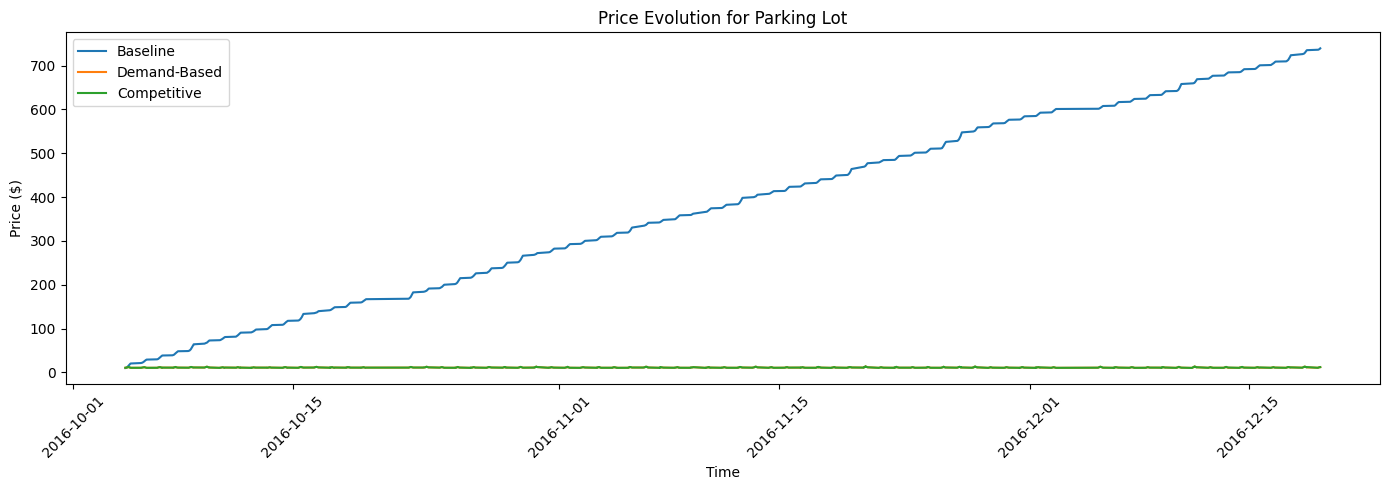

In [35]:
# Ensure timestamp is valid and drop rows with missing prices
sample_lot = df[df['SystemCodeNumber'] == df['SystemCodeNumber'].unique()[0]].copy()
sample_lot = sample_lot.dropna(subset=['BaselinePrice', 'DemandPrice', 'CompetitivePrice', 'Timestamp'])
sample_lot = sample_lot.sort_values(by='Timestamp')

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
sns.lineplot(x='Timestamp', y='BaselinePrice', data=sample_lot, label="Baseline")
sns.lineplot(x='Timestamp', y='DemandPrice', data=sample_lot, label="Demand-Based")
sns.lineplot(x='Timestamp', y='CompetitivePrice', data=sample_lot, label="Competitive")
plt.title("Price Evolution for Parking Lot")
plt.ylabel("Price ($)")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


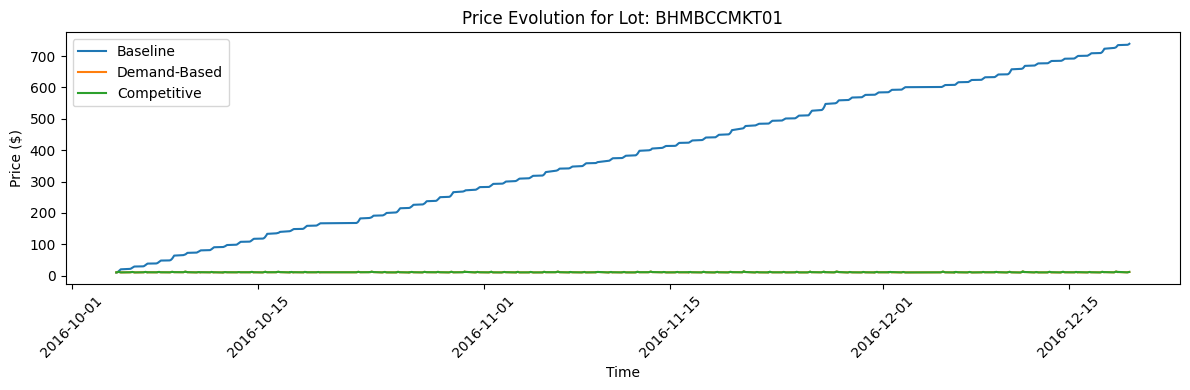

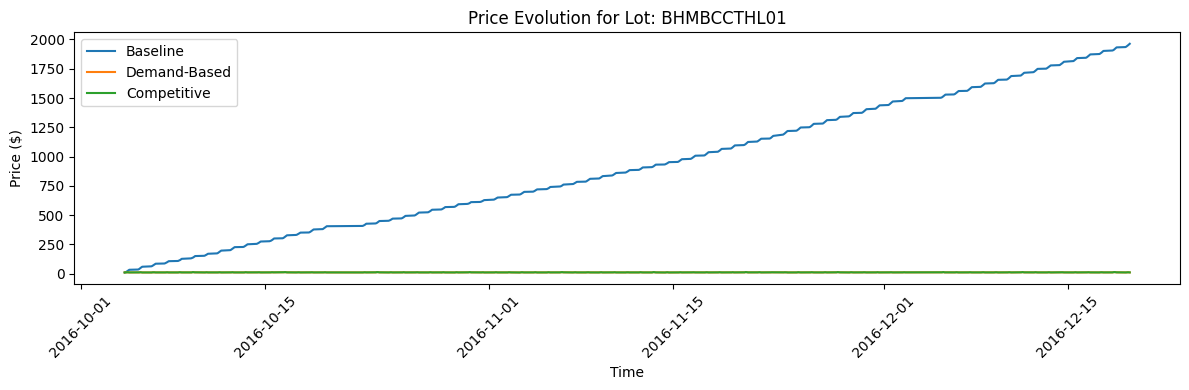

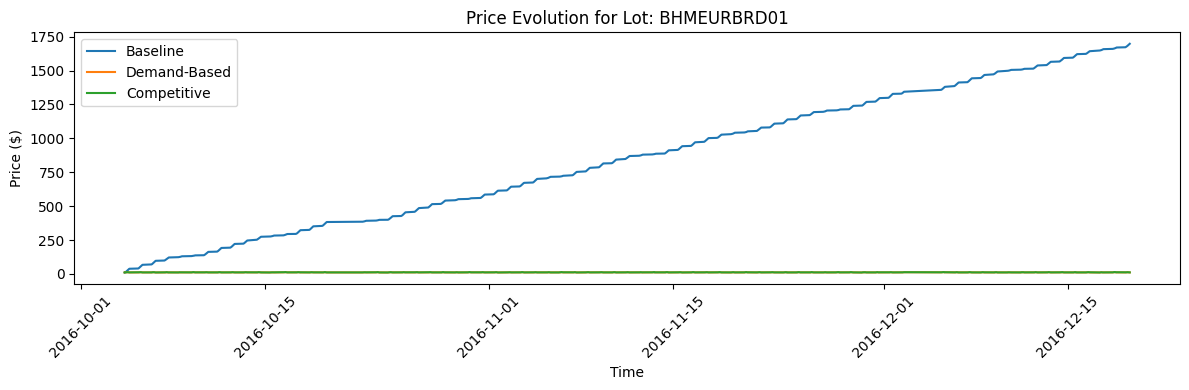

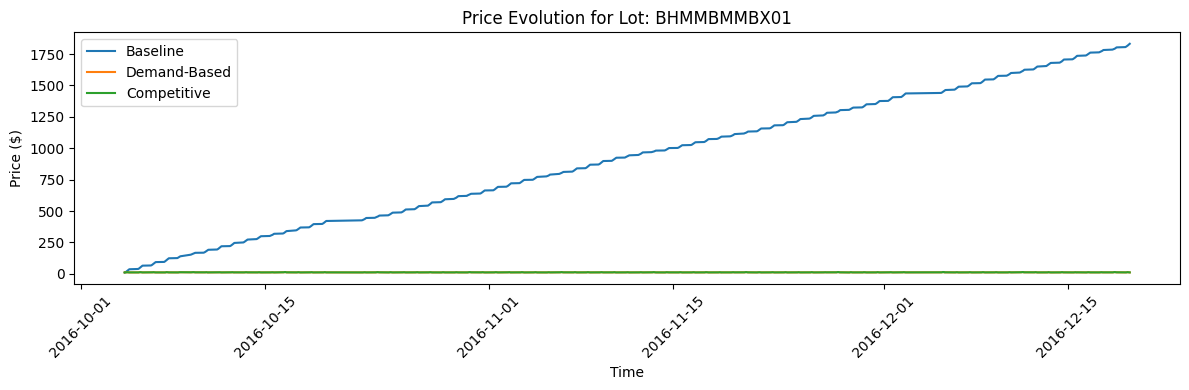

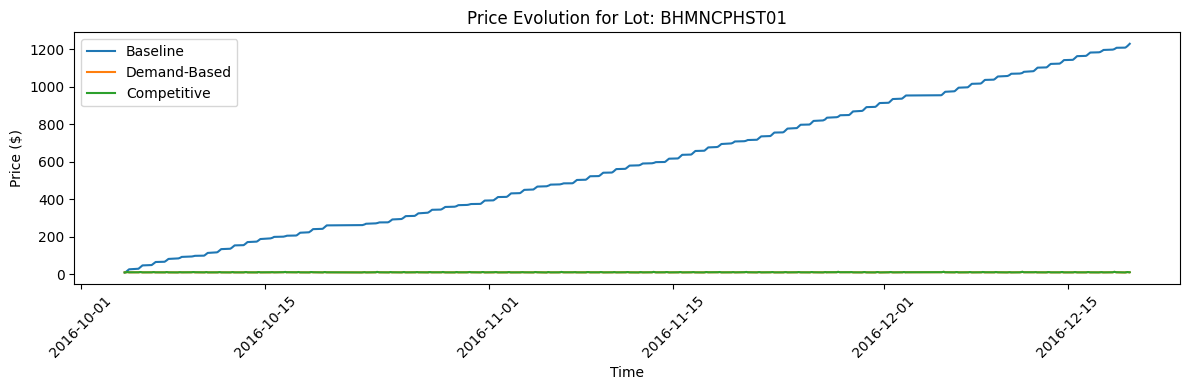

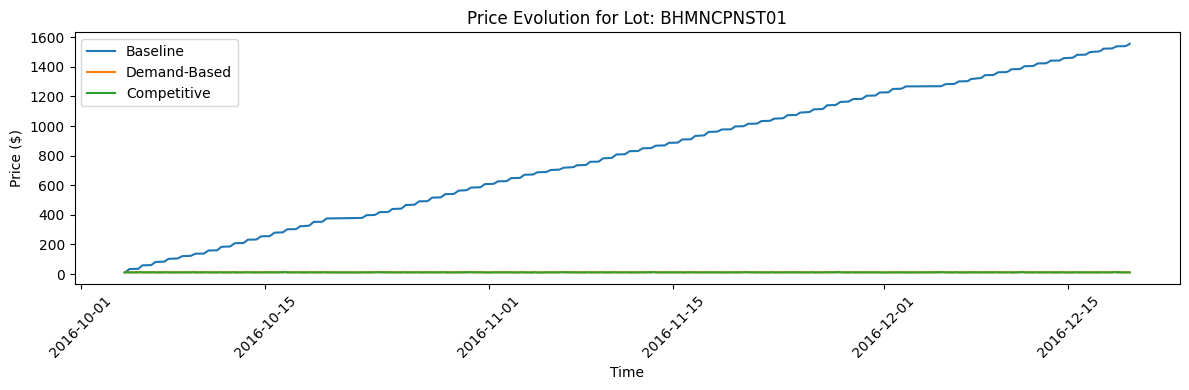

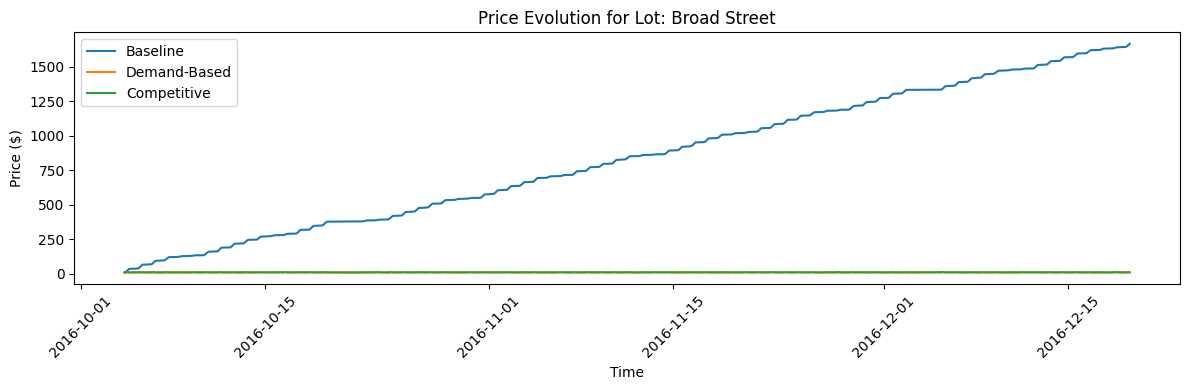

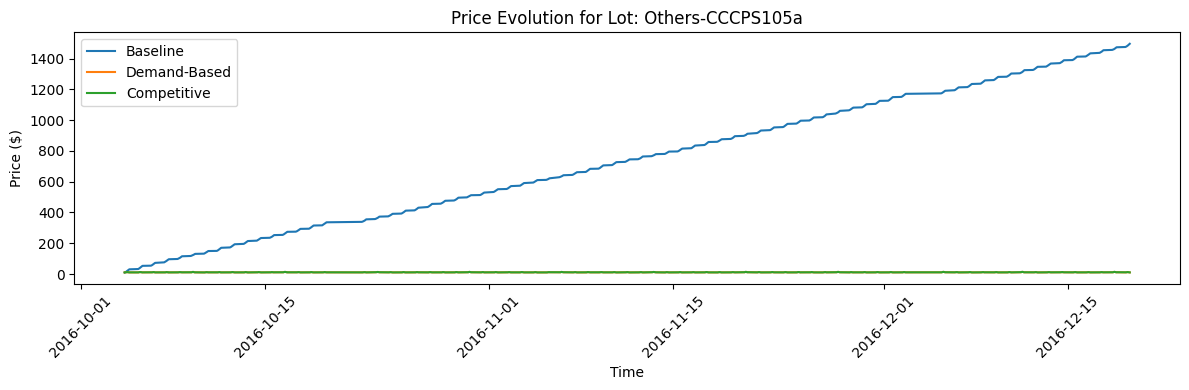

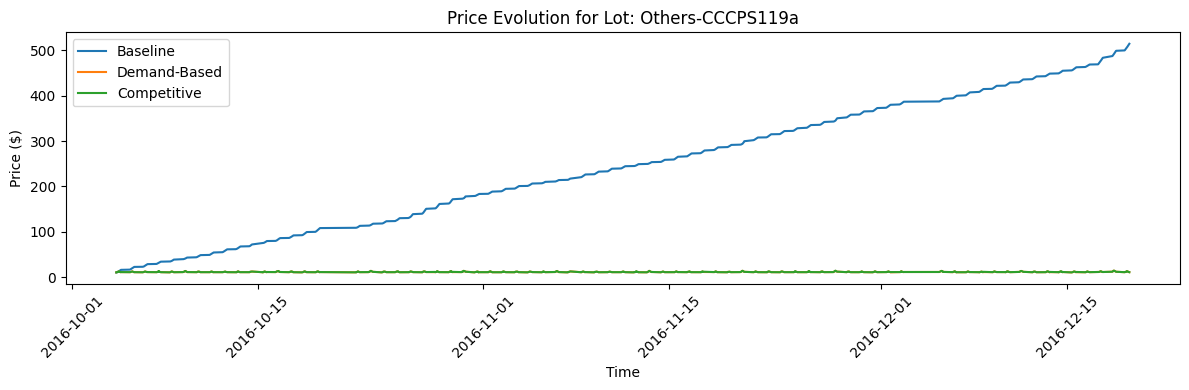

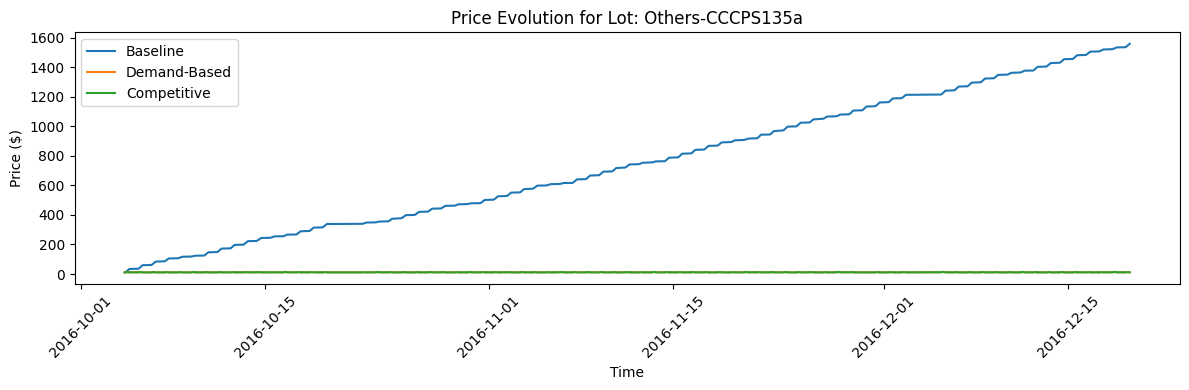

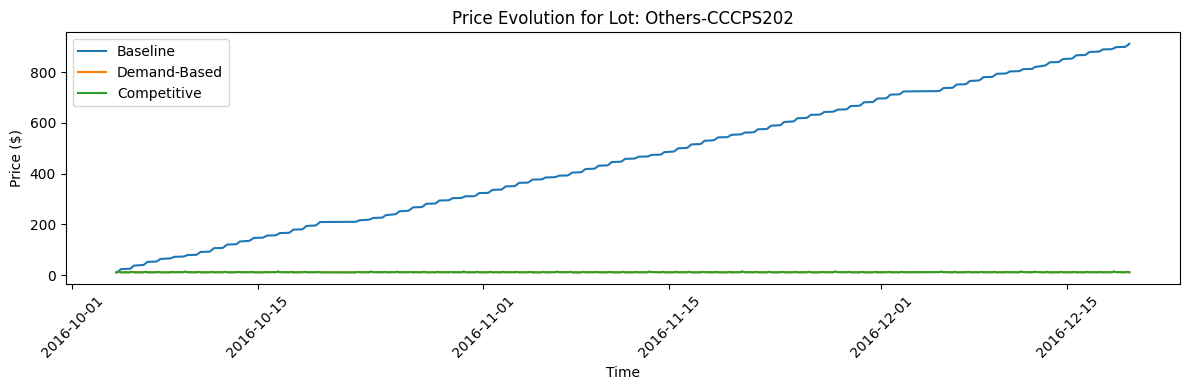

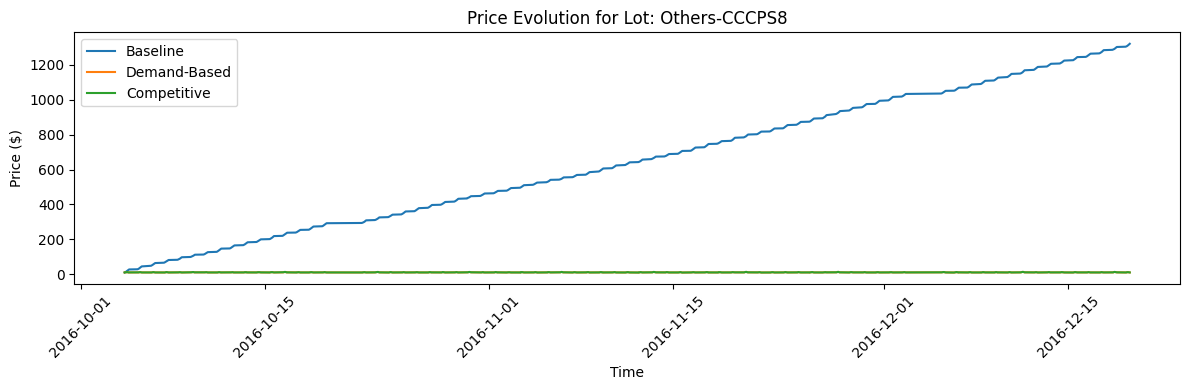

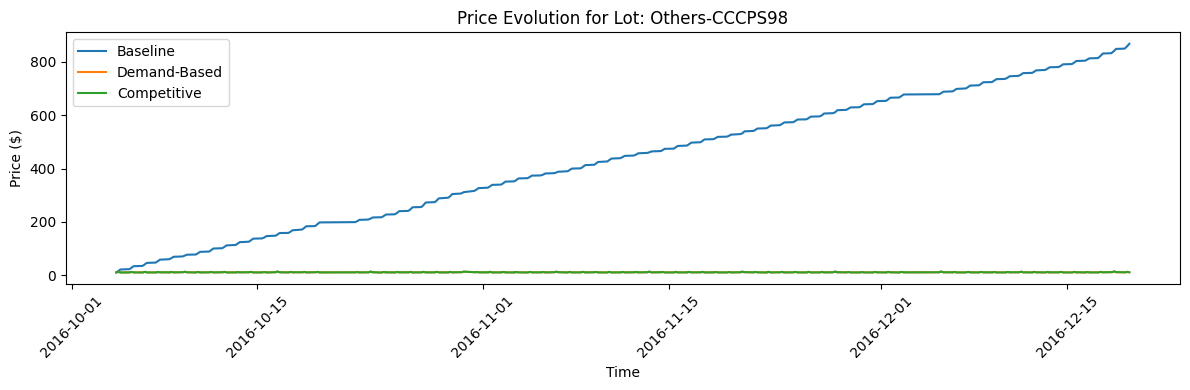

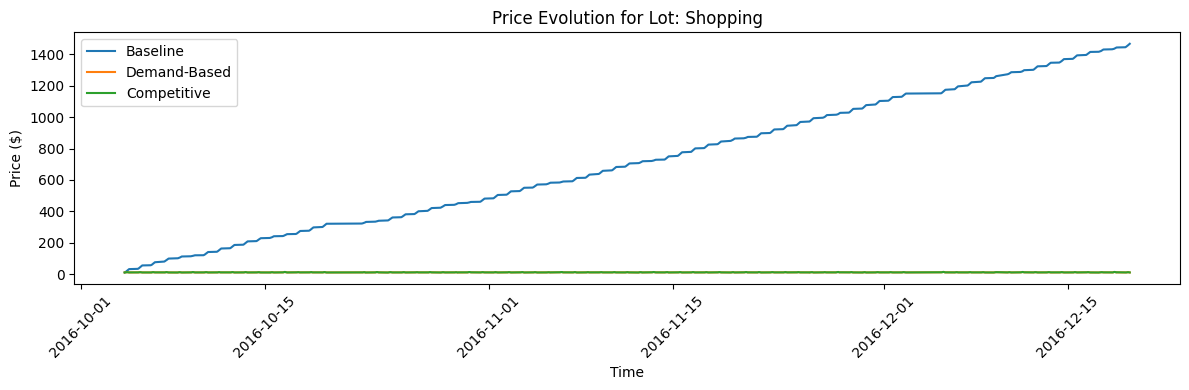

In [37]:
unique_lots = df['SystemCodeNumber'].unique()

for lot in unique_lots:
    lot_df = df[df['SystemCodeNumber'] == lot].copy()
    lot_df = lot_df.dropna(subset=['BaselinePrice', 'DemandPrice', 'CompetitivePrice', 'Timestamp'])
    lot_df = lot_df.sort_values(by='Timestamp')

    plt.figure(figsize=(12, 4))
    sns.lineplot(x='Timestamp', y='BaselinePrice', data=lot_df, label='Baseline')
    sns.lineplot(x='Timestamp', y='DemandPrice', data=lot_df, label='Demand-Based')
    sns.lineplot(x='Timestamp', y='CompetitivePrice', data=lot_df, label='Competitive')
    plt.title(f"Price Evolution for Lot: {lot}")
    plt.xticks(rotation=45)
    plt.ylabel("Price ($)")
    plt.xlabel("Time")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [38]:
# ✅ 1. Install Pathway
!pip install pathway --quiet


In [43]:
# ✅ 2. Imports
import pandas as pd
import numpy as np
from datetime import datetime
import pathway as pw


In [44]:
# ✅ 3. Load and preprocess your data
df = pd.read_csv('dataset.csv')

# Fix datetime format
df['Timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    format='%d-%m-%Y %H:%M:%S',
    errors='coerce'
)

# Map vehicle types
vehicle_weights = {'car': 1.0, 'bike': 0.6, 'truck': 1.5}
df['VehicleWeight'] = df['VehicleType'].map(vehicle_weights)

# Map traffic condition
traffic_weights = {'low': 1, 'medium': 2, 'high': 3}
df['TrafficWeight'] = df['TrafficConditionNearby'].map(traffic_weights)

# Drop rows with missing essential values
df = df.dropna(subset=['Timestamp', 'VehicleWeight', 'TrafficWeight'])

# Optional: sort for realism
df = df.sort_values(by='Timestamp').reset_index(drop=True)


In [45]:
# ✅ 4. Define the pricing function (Model 2 logic)
def compute_demand_price(row, base_price=10, λ=0.5):
    occupancy_rate = row["Occupancy"] / row["Capacity"]
    demand = (
        0.4 * occupancy_rate +
        0.3 * row["QueueLength"] +
        0.2 * row["IsSpecialDay"] +
        0.3 * row["VehicleWeight"] -
        0.3 * row["TrafficWeight"]
    )
    # Normalize demand to [0, 1]
    norm_demand = min(max((demand + 3) / 6, 0), 1)
    price = base_price * (1 + λ * norm_demand)
    return round(min(max(price, base_price * 0.5), base_price * 2.0), 2)


In [47]:
# ✅ 5. Define Pathway connector to simulate row-by-row stream
def stream_parking_rows(df):
    for _, row in df.iterrows():
        yield {
            "SystemCodeNumber": row["SystemCodeNumber"],
            "Occupancy": int(row["Occupancy"]),
            "Capacity": int(row["Capacity"]),
            "QueueLength": int(row["QueueLength"]),
            "IsSpecialDay": int(row["IsSpecialDay"]),
            "VehicleWeight": float(row["VehicleWeight"]),
            "TrafficWeight": int(row["TrafficWeight"]),
            "Timestamp": row["Timestamp"]
        }

